In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
%cd /Users/gjain/Documents/xom

/Users/gjain/Documents/xom


# Project objective: Average house price (WOZ) prediction for an area in Amsterdam

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from category_encoders.ordinal import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.utils.constants import TARGET

In [5]:
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [6]:
base_dir = Path("/Users/gjain/Documents/xom")
data = base_dir / "data"

# Read in training data

In [7]:
input_path = data / "02_intermediate/train_feature_engg.csv"
train = pd.read_parquet(input_path)

abs_cols_new = {col: col.replace(" ", "_").replace(",", "") for col in train.columns}

train.rename(mapper=abs_cols_new, inplace=True, axis=1)

train.head()

,area,single,married_no_kids,not_married_no_kids,married_with_kids,not_married_with_kids,single_parent,other,total,avg_woz,woz_per_msq,borough,perc_area_single,perc_area_married_no_kids,perc_area_not_married_no_kids,perc_area_married_with_kids,perc_area_not_married_with_kids,perc_area_single_parent,perc_area_other,perc_of_tot_fam_type_single,perc_of_tot_fam_type_married_no_kids,perc_of_tot_fam_type_not_married_no_kids,perc_of_tot_fam_type_married_with_kids,perc_of_tot_fam_type_not_married_with_kids,perc_of_tot_fam_type_single_parent,perc_of_tot_fam_type_other,area_has_buurt,area_has_burg,area_has_dijk,area_has_park,area_has_plein,area_has_nieuw,area_has_gracht,area_has_dorp,Highest_income_hhs,Touristy,Diversity,HasHomeStadium,IsPosh
0,F82c Zuidwestkwadrant Osdorp Noord,616.0000,173.0000,129.0000,285.0000,54.0000,141.0000,37.0000,1435.0000,186984.0000,2106.0000,Neiuw-West,42.9268,12.0557,8.9895,19.8606,3.7631,9.8258,2.5784,0.2906,0.4728,0.2849,0.6160,0.2851,0.3898,0.6652,False,False,False,False,False,False,False,True,0,9,9,9,9
1,T97a Gein Noordwest,918.0000,75.0000,123.0000,103.0000,80.0000,308.0000,22.0000,1629.0000,127038.0000,1803.0000,Zuidoost,56.3536,4.6041,7.5506,6.3229,4.9110,18.9073,1.3505,0.4331,0.2050,0.2717,0.2226,0.4224,0.8516,0.3955,False,False,False,False,False,False,False,False,0,4,9,1,9
2,T94g K-buurt Zuidoost,129.0000,20.0000,35.0000,84.0000,41.0000,56.0000,8.0000,373.0000,203325.0000,1758.0000,Zuidoost,34.5844,5.3619,9.3834,22.5201,10.9920,15.0134,2.1448,0.0609,0.0547,0.0773,0.1816,0.2165,0.1548,0.1438,True,False,False,False,False,False,False,False,0,4,9,1,9
3,M31c Zuidwestkwadrant Indische Buurt,1038.0000,168.0000,195.0000,346.0000,69.0000,209.0000,25.0000,2050.0000,183293.0000,2600.0000,Oost,50.6341,8.1951,9.5122,16.8780,3.3659,10.1951,1.2195,0.4898,0.4591,0.4307,0.7478,0.3643,0.5778,0.4495,True,False,False,False,False,False,False,False,0,4,1,9,9
4,F88f Nieuw Sloten Noordoost,460.0000,313.0000,104.0000,304.0000,80.0000,127.0000,16.0000,1404.0000,248766.0000,2380.0000,Neiuw-West,32.7635,22.2934,7.4074,21.6524,5.6980,9.0456,1.1396,0.2170,0.8553,0.2297,0.6570,0.4224,0.3511,0.2877,False,False,False,False,False,True,False,False,0,9,9,9,9


In [8]:
train.shape

(343, 39)

# Train and validation split

In [9]:
train, valid = train_test_split(
    train, test_size=0.2, random_state=26, shuffle=12, stratify=None
)
print(train.shape, valid.shape)

(274, 39) (69, 39)


In [10]:
y_train = train.loc[:, [TARGET]]
X_train = train.copy(deep=True)
X_train.drop(columns=["area", TARGET], inplace=True)
X_train.shape

y_valid = valid.loc[:, [TARGET]]
X_valid = valid.copy(deep=True)
X_valid.drop(columns=["area", TARGET], inplace=True)
X_train.shape, X_valid.shape

((274, 37), (69, 37))

In [26]:
X_train.to_parquet(data / "02_intermediate/X_train.csv", index=None)
X_valid.to_parquet(data / "02_intermediate/X_valid.csv", index=None)
y_train.to_parquet(data / "02_intermediate/y_train.csv", index=None)
y_valid.to_parquet(data / "02_intermediate/y_valid.csv", index=None)

We will use evaluation metric: MAE

# Baseline model
Borough avg woz is area's avg woz prediction

In [11]:
borough_mean = train.groupby("borough")[TARGET].mean()
borough_mean = pd.DataFrame(borough_mean).reset_index()
borough_mean

,borough,avg_woz
0,Centrum,329031.8750
1,Neiuw-West,206334.3438
2,Noord,225285.5781
3,Oost,246292.8281
4,West,229158.4688
5,Zuid,357122.2188
6,Zuidoost,146749.0000


In [12]:
interim_train = train.loc[:, ["borough", TARGET]].merge(
    borough_mean, how="left", on="borough"
)

interim_valid = valid.loc[:, ["borough", TARGET]].merge(
    borough_mean, how="left", on="borough"
)

interim_train.head()

,borough,avg_woz_x,avg_woz_y
0,Zuidoost,117875.0000,146749.0000
1,Oost,197258.0000,246292.8281
2,Oost,147582.0000,246292.8281
3,Centrum,330551.0000,329031.8750
4,Zuidoost,139795.0000,146749.0000


In [13]:
print(
    f"Baseline training MAE is {mean_absolute_error(interim_train['avg_woz_x'],interim_train['avg_woz_y']):.2f}"
)
print(
    f"Baseline training MAPE is {mean_absolute_percentage_error(interim_train['avg_woz_x'],interim_train['avg_woz_y']):.2f}"
)

print(
    f"Baseline validation MAE is {mean_absolute_error(interim_valid['avg_woz_x'],interim_valid['avg_woz_y']):.2f}"
)
print(
    f"Baseline validation MAPE is {mean_absolute_percentage_error(interim_valid['avg_woz_x'],interim_valid['avg_woz_y']):.2f}"
)

Baseline training MAE is 73873.95
Baseline training MAPE is 0.31
Baseline validation MAE is 82972.20
Baseline validation MAPE is 0.30


### Comparing various algorithms

In [14]:
abs_cols = [
    "single",
    "married_no_kids",
    "not_married_no_kids",
    "married_with_kids",
    "not_married_with_kids",
    "single_parent",
    "other",
]
perc_area_cols = [
    "perc_area_single",
    "perc_area_married_no_kids",
    "perc_area_not_married_no_kids",
    "perc_area_married_with_kids",
    "perc_area_not_married_with_kids",
    "perc_area_single_parent",
    "perc_area_other",
]

perc_of_tot_fam_cols = [
    "perc_of_tot_fam_type_single",
    "perc_of_tot_fam_type_married_no_kids",
    "perc_of_tot_fam_type_not_married_no_kids",
    "perc_of_tot_fam_type_married_with_kids",
    "perc_of_tot_fam_type_not_married_with_kids",
    "perc_of_tot_fam_type_single_parent",
    "perc_of_tot_fam_type_other",
]

borough_details = [
    "Highest_income_hhs",
    "Touristy",
    "Diversity",
    "HasHomeStadium",
    "IsPosh",
]
other_cols = [
    "total",
]

area_has_cols = [
    "area_has_buurt",
    #     "area_has_burg",
    #     "area_has_dijk",
    #     "area_has_park",
    #     "area_has_plein",
    #     "area_has_nieuw",
    #     "area_has_gracht",
    #     "area_has_dorp",
]

other_cols_cat = "borough"

In [19]:
model_features = perc_area_cols + abs_cols + other_cols
print(len(model_features))

15


#### Linear regression

In [18]:
for a in np.linspace(0, 1, 10, endpoint=False):
    est = Ridge(
        alpha=a,
    )
    est.fit(X_train.loc[:, model_features], y_train)

    ridge_pred_train = est.predict(X_train[model_features])
    ridge_pred_valid = est.predict(X_valid[model_features])

    print(
        a,
        mean_absolute_percentage_error(y_train, ridge_pred_train),
        mean_absolute_percentage_error(y_valid, ridge_pred_valid),
        mean_absolute_error(y_train, ridge_pred_train),
        mean_absolute_error(y_valid, ridge_pred_valid),
    )

# coefs = pd.DataFrame(est.coef_[0], columns=["Coefficients"], index=model_features)
# coefs

0.0 0.32407668 0.31013075 69297.56 79143.74
0.1 0.29744235 0.2901169 65611.47 75762.56
0.2 0.29744068 0.2901174 65611.266 75762.36
0.30000000000000004 0.29743907 0.29011795 65611.06 75762.17
0.4 0.29743743 0.29011855 65610.86 75762.0
0.5 0.29743585 0.2901191 65610.67 75761.84
0.6000000000000001 0.29743424 0.29011965 65610.47 75761.65
0.7000000000000001 0.29743257 0.29012024 65610.27 75761.47
0.8 0.29743096 0.29012072 65610.06 75761.28
0.9 0.29742938 0.2901213 65609.87 75761.11


#### Random Forest

0.14932908524239072 0.2743192526662373 36619.44604014599 70032.46942028987


<AxesSubplot:>

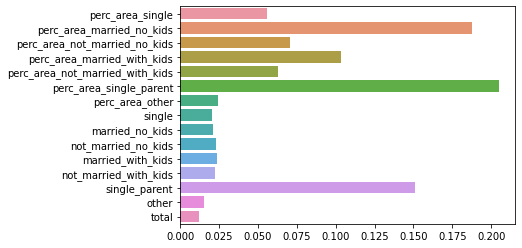

In [23]:
est_rf = RandomForestRegressor(criterion="mae", max_depth=5)

est_rf.fit(
    X_train.loc[:, model_features],
    np.array(y_train).reshape(
        -1,
    ),
)

rf_pred_train = est_rf.predict(X_train[model_features])
rf_pred_valid = est_rf.predict(X_valid[model_features])

print(
    mean_absolute_percentage_error(y_train, rf_pred_train),
    mean_absolute_percentage_error(y_valid, rf_pred_valid),
    mean_absolute_error(y_train, rf_pred_train),
    mean_absolute_error(y_valid, rf_pred_valid),
)

sns.barplot(x=est_rf.feature_importances_, y=model_features)

0.01378275235572584 0.265075086890387 3253.759428227754 66746.96161758495


<AxesSubplot:>

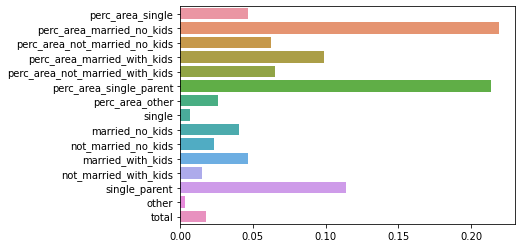

In [24]:
est_rf = GradientBoostingRegressor(max_depth=5, loss="ls")

est_rf.fit(
    X_train.loc[:, model_features],
    np.array(y_train).reshape(
        -1,
    ),
)

rf_pred_train = est_rf.predict(X_train[model_features])
rf_pred_valid = est_rf.predict(X_valid[model_features])

print(
    mean_absolute_percentage_error(y_train, rf_pred_train),
    mean_absolute_percentage_error(y_valid, rf_pred_valid),
    mean_absolute_error(y_train, rf_pred_train),
    mean_absolute_error(y_valid, rf_pred_valid),
)

sns.barplot(x=est_rf.feature_importances_, y=model_features)